In [9]:
import sys
sys.path.insert(1, r"/vol/bitbucket/mjh24/IAEA-thesis")
import os
os.environ.setdefault("HF_HOME", "/data/mjh24/hf")
os.environ.setdefault("TRANSFORMERS_CACHE", "/data/mjh24/hf/transformers")
os.makedirs(os.environ["TRANSFORMERS_CACHE"], exist_ok=True)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
from Stage1.GAT.GATModel import GraphAttentionNetwork
from Single_Website_Download.Download import main as downloadHTML
import torch
from Stage1.ExtractingGraphs.seleniumDriver import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import *
from Stage2.txtGraphPruning.display_txt_graph import draw_graph_from_arrays
from Stage2.txtGraphPruning.prune_txt_graph import main as prune_txt_graph
from Stage2.txtGraphPruning.graph_clustering import leiden_clustering, mini_graphs_from_clusters, louvain_clustering
from Stage2.classifyingEdges.classifyingFLANT5 import clean_instructional_text, classify_link_pairs_flan_batched
from Stage2.classifyingEdges.classifyingDeBerta import classify_node_isSentence, classify_node_isCatgory
from Stage2.classifyingEdges.rewritingOPENAI import add_context, summairse, summairse_clusters
from Stage2.classifyingEdges.classifyingOpenAI import classify_needsContext_openAI, classify_link_pairs_openAI, classify_pairwiseEdges_openAI
from Stage2.classifyingEdges.metrics import metrics
from itertools import combinations
from collections import defaultdict
from pathlib import Path
import numpy as np

CLIP_TO_N_EDGES_PER_NODE = 10 # This is to clip all the outgoing edges per node to a certain number
device = device or ("cuda" if torch.cuda.is_available() else "cpu")
REMOVE_DUPES = False

### Step 1. ###
Load the model and download the website

In [10]:
# Load model
# model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
# state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/Stage1/GAT/LONG80EPOCH-75f1-newlabelnotitle.pt", map_location=torch.device(device))
model = GraphAttentionNetwork(in_dim = 119, pe_dim=11, edge_in_dim = 210, edge_emb_dim = 32, heads = 4)
state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/TrueTransformer-newtagsnotitle.pt", map_location=torch.device(device))
model.load_state_dict(state_dict, strict=False)
model.to(device)

# Load the website
#htmlFile = "/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0000.htm"
# url = r"https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024"
# url = "https://westinghousenuclear.com/"
# url = "https://www.football.co.uk/news/leeds-vs-bournemouth-premier-league-team-news-lineups-prediction/781112/"
# url = r"https://www.bbc.co.uk/news/live/cev28rvzlv1t"
url = "https://www.nfl.com/teams/" # Great to show teams and structured data
# url = "https://www.energy.gov/ne/articles/advantages-and-challenges-nuclear-energy" #Great to show semi structured webpages with titles
# url = "https://westinghousenuclear.com/nuclear-fuel/fuel-fabrication-operations/"
# url = "https://www.livescore.com/en/football/england/premier-league/bournemouth-vs-leicester-city/1250940/lineups/"
htmlFile = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html")
downloadHTML(url,1,htmlFile)

Saved https://www.nfl.com/teams/ → /vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html
Page limit hit


### Step 2. ###
Apply the graph model to extract all the possible edges.
This extracts all text nodes found and outputs all possible edges, along with their probabilities

In [11]:
# Get label edges from text nodes in the website
#sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted = txtExtractor(htmlFile, model, alreadyConvertedToGraph="/vol/bitbucket/mjh24/IAEA-thesis/data/0000_test", remove_dupes=REMOVE_DUPES)
sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted, title_label, title_txt, title_xpaths, title_probs = txtExtractor(htmlFile, model, remove_dupes=REMOVE_DUPES)
model.to("cpu")         # offload to CPU
if torch.cuda.is_available():
    torch.cuda.empty_cache() # reclaim GPU cache

In [12]:
for i in range(len(title_txt)):
    print(title_txt[i], title_probs[i])

View Full Site 0.030125605
View Full Site 0.023878664
View Full Site 0.022463853
View Full Site 0.018186454
View Profile 0.015158645
View Full Site 0.01238925
View Profile 0.009428119
View Full Site 0.009174224
View Full Site 0.0076879314
View Full Site 0.007440621
View Full Site 0.007075618
View Profile 0.0062003694
View Profile 0.0057411264
View Full Site 0.004308248
View Full Site 0.0041215075
Skip to main content 0.003760382
View Profile 0.003727608
View Profile 0.0033217254
View Full Site 0.0032037804
View Full Site 0.0029315979
Denver Broncos 0.002915068
Tampa Bay Buccaneers 0.0028301345
Carolina Panthers 0.0026625202
Seattle Seahawks 0.0025164366
View Full Site 0.0024925962
Baltimore Ravens 0.0024783188
Dallas Cowboys 0.0024182643
New York Giants 0.0020029387
The browser you are using is no longer supported on this site. It is highly recommended that you use the latest versions of a supported browser in order to receive an optimal viewing experience. The following browsers are s

In [13]:
# Normalise the text
normtxt = []
for a, b in txts_extracted:
    normtxt.append([normalise_text(a, ",:\\-.%'\\s", lower=False), normalise_text(b, ",:\\-.%'\\s", lower=False)])
txts, probs, sorted_label_index, xpaths = np.array(normtxt), np.array(probs_extracted), np.array(sorted_label_index_extracted), np.array(xpaths_extracted)

Extract unique nodes from the edges and create a mapping from node to edge

In [14]:
node_unique_label_index, node_to_edge_pos = np.unique(sorted_label_index, return_index=True)
node_to_edge_pos = np.array([[int(idx/2),0] if idx%2==0 else [int(idx/2),1] for idx in node_to_edge_pos])
node_to_edge_x_pos, node_to_edge_y_pos = node_to_edge_pos[:,0], node_to_edge_pos[:,1]

node_unique_txts, node_unique_xpaths = txts[node_to_edge_x_pos,node_to_edge_y_pos], xpaths[node_to_edge_x_pos, node_to_edge_y_pos]
for a,b, in zip (node_unique_txts, node_unique_xpaths):
    print(a,b)

Skip to main content /html/body/a
The browser you are using is no longer supported on this site. It is highly recommended that you use the latest versions of a supported browser in order to receive an optimal viewing experience. The following browsers are supported: Chrome, Edge v80 and later, Firefox and Safari. Got it /html/body/div[6]
NFC Teams /html/body/div[3]/main/section/div/div[2]/section/div/div[1]/div/h2
AFC Teams /html/body/div[3]/main/section/div/div[3]/section/div/div[1]/div/h2
Arizona Cardinals /html/body/div[3]/main/section/div/div[2]/section/div/div[2]/div/div/div/h4
Atlanta Falcons /html/body/div[3]/main/section/div/div[2]/section/div/div[3]/div/div/div/h4
Carolina Panthers /html/body/div[3]/main/section/div/div[2]/section/div/div[4]/div/div/div/h4
Chicago Bears /html/body/div[3]/main/section/div/div[2]/section/div/div[5]/div/div/div/h4
Dallas Cowboys /html/body/div[3]/main/section/div/div[2]/section/div/div[6]/div/div/div/h4
Detroit Lions /html/body/div[3]/main/sectio

### Step 3. ###
This filters out all the nodes where the text is a button/navigational link.

This uses a FLAN-T5 model

In [15]:
# Remove all html instructional labels
txtsShortened = [[a.split(".")[0], b.split(".")[0]] for a, b in txts]
isButton, buttonTxt = clean_instructional_text(txtsShortened, batch_size=16)
opmask = np.array(isButton, dtype=bool)
mask = np.logical_not(opmask)

print("All the nodes filtered out:\n\n")
isButtonNode = np.zeros_like(node_unique_txts, dtype=bool)
for key, value in buttonTxt.items():
    if value == 1:
        idx = np.where(node_unique_txts==key)
        print(len(idx[0]),"-",key)
        isButtonNode[idx] = True

All the nodes filtered out:


32 - View Profile
32 - View Full Site
1 - Skip to main content


In [16]:
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
node_unique_label_index, node_to_edge_pos, node_unique_txts, node_unique_xpaths = node_unique_label_index[~isButtonNode], node_to_edge_pos[~isButtonNode], node_unique_txts[~isButtonNode], node_unique_xpaths[~isButtonNode]

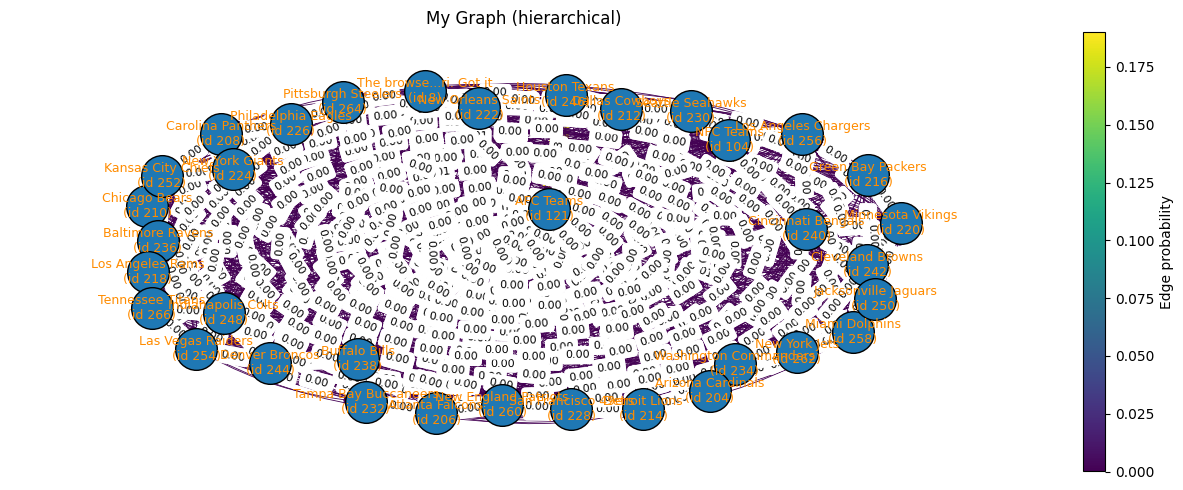

In [17]:
# Displaying the graph before all the pruning steps
_=draw_graph_from_arrays(
    txt_edge_pairs=txts,
    id_edge_pairs=sorted_label_index,
    xpath_edge_pairs=xpaths,
    probs=probs,
    layout="spring",
    rankdir="TB",         # or "TB" for top→bottom
    layer_spacing=1.5,    # spread layers further
    node_spacing=10,     # spread nodes within a layer
    figsize=(12, 5),
    title="My Graph (hierarchical)",
)

### Step 4. ###
This filters out all the low probability edges using the finding from the probability paper. At least two edges per node are saved

In [18]:
# -- RUN THE MAIN PRUNING MASK --
mask = prune_txt_graph(probs, sorted_label_index, toloerance=0.01, remove_dupes=REMOVE_DUPES)

# Concatanate and apply masks if we want specific text
mask = np.array(mask, dtype=bool) 
print(len(sorted_label_index), " -> ", len(sorted_label_index[mask]))
[print(edge) for edge in txts[~mask]]
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
# -- PRUNING FINISHED --

1190  ->  67
['NFC Teams' 'Houston Texans']
['Houston Texans' 'NFC Teams']
['NFC Teams' 'Buffalo Bills']
['Buffalo Bills' 'NFC Teams']
['NFC Teams' 'Miami Dolphins']
['Miami Dolphins' 'NFC Teams']
['NFC Teams' 'Indianapolis Colts']
['Indianapolis Colts' 'NFC Teams']
['Chicago Bears' 'AFC Teams']
['AFC Teams' 'Chicago Bears']
['Carolina Panthers' 'AFC Teams']
['AFC Teams' 'Carolina Panthers']
['NFC Teams' 'New York Jets']
['New York Jets' 'NFC Teams']
['NFC Teams' 'Pittsburgh Steelers']
['Pittsburgh Steelers' 'NFC Teams']
['The browser you are using is no longer supported on this site. It is highly recommended that you use the latest versions of a supported browser in order to receive an optimal viewing experience. The following browsers are supported: Chrome, Edge v80 and later, Firefox and Safari. Got it'
 'NFC Teams']
['NFC Teams' 'Denver Broncos']
['Denver Broncos' 'NFC Teams']
['Tampa Bay Buccaneers' 'AFC Teams']
['AFC Teams' 'Tampa Bay Buccaneers']
['NFC Teams' 'Los Angeles Charge

### Step 5. ###
This filters out all the edges where the two text nodes make no sense together (i.e. they talk about different things)

In [19]:
# Classify the edges
#classificationDeBerta, scoresDeberta = classify_link_pairs_zero_shot(txts, batch_size=64, confidence_Factor=0.9, return_scores=True)
#classificationDeBerta_twostep = classify_link_pairs_zero_shot_two_step(txts, batch_size=64, return_scores=False)
classificationFlan = classify_link_pairs_flan_batched(txts, batch_size=32)
#classificationOpenAI = classify_link_pairs_openAI(txts[:40])
#print(classificationDeBerta)
#print(classificationFlan)
#print(classificationDeBerta_twostep)
#print(classificationOpenAI)


In [20]:
#Quick informal test
# y_true_str = "2 2 1 1 ? ? ? ? 3 3 1 1 3 3 2 2 2 2 1 1 ? ? 1 1 3 3 1 1 3 3 1 1 1 1 2 2 2 2 2 2"
# #classificationOpenAI = [1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1]
# y_true = [3 if tok == "?" else int(tok) for tok in y_true_str.split()]

In [21]:
#metrics(classificationDeBerta[:len(y_true)], y_true)
#metrics(classificationFlan[:len(y_true)], y_true)
#metrics(classificationDeBerta_twostep[:len(y_true)], y_true)
#metrics(classificationOpenAI[:len(y_true)], y_true)

In [22]:
# if len(classificationFlan) != len(txts):
#     raise Exception("The classification is not the same length as the number of edges")
# for (pair, lab) in zip(txts, classificationFlan):
#         print(lab, pair)

#for (pair, lab, sc) in zip(txts, classificationDeBerta, scoresDeberta or []):
#        print(lab, pair, "| scores:", {k: round(v, 3) for k, v in sc.items()})

In [23]:
mask = np.array([(False if i==3 else True) for i in classificationFlan])
print("Removing the following edges:\n\n", txts[~mask])
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]

Removing the following edges:

 [['NFC Teams'
  'The browser you are using is no longer supported on this site. It is highly recommended that you use the latest versions of a supported browser in order to receive an optimal viewing experience. The following browsers are supported: Chrome, Edge v80 and later, Firefox and Safari. Got it']
 ['AFC Teams'
  'The browser you are using is no longer supported on this site. It is highly recommended that you use the latest versions of a supported browser in order to receive an optimal viewing experience. The following browsers are supported: Chrome, Edge v80 and later, Firefox and Safari. Got it']]


### 6. Finding each node that needs context to make a complete fact ###

    1) It uses DeBERTa-v3 model to split the nodes into more than a phrase and less that a phrase

For those that are <b> more than a phrase </b>

    2.1) GPT_4.1_mini decides if the sentences need more context

For those that are <b> less than a phrase </b>

    2.2) Use DeBERTa to categorise the value

The reason they are split is that it is a lot easier to create sentences from small "value to value" pairs. It is also good as the "value to sentence" edges are easier to extract information from if we know which are sentences (that need context) and which are values (that give context).

In [24]:
isSentence, isSentence_probs = classify_node_isSentence(node_unique_txts.tolist(), batch_size=32)
for isS, txt in zip(isSentence, node_unique_txts):
    print(isS, txt)

1 The browser you are using is no longer supported on this site. It is highly recommended that you use the latest versions of a supported browser in order to receive an optimal viewing experience. The following browsers are supported: Chrome, Edge v80 and later, Firefox and Safari. Got it
0 NFC Teams
0 AFC Teams
0 Arizona Cardinals
0 Atlanta Falcons
0 Carolina Panthers
0 Chicago Bears
0 Dallas Cowboys
0 Detroit Lions
0 Green Bay Packers
0 Los Angeles Rams
0 Minnesota Vikings
0 New Orleans Saints
0 New York Giants
0 Philadelphia Eagles
0 San Francisco 49ers
0 Seattle Seahawks
0 Tampa Bay Buccaneers
0 Washington Commanders
0 Baltimore Ravens
0 Buffalo Bills
0 Cincinnati Bengals
0 Cleveland Browns
0 Denver Broncos
0 Houston Texans
0 Indianapolis Colts
0 Jacksonville Jaguars
0 Kansas City Chiefs
0 Las Vegas Raiders
0 Los Angeles Chargers
0 Miami Dolphins
0 New England Patriots
0 New York Jets
0 Pittsburgh Steelers
0 Tennessee Titans


In [25]:
isSentence = np.array(isSentence, dtype=bool)
node_sentences, node_sentences_xpaths = node_unique_txts[isSentence], node_unique_xpaths[isSentence]
if len(node_sentences) > 0:
    ####################################################################################################################Random to not waste money
    #sentenceNeedsContext = np.random.randint(2, size=node_sentences.shape)#
    sentenceNeedsContext, cost_needsContext, _ = classify_needsContext_openAI(node_sentences, dry_run_confirm=False, batch_size=1, return_raw_response_and_cost=True)
    ####################################################################################################################
    sentenceNeedsContext=np.array(sentenceNeedsContext, dtype=bool)
    #Re padding and getting back to the dimension of node_unique_txts
else:
    sentenceNeedsContext, cost_needsContext = np.zeros(node_sentences.shape, dtype=bool), 0
padded_sentenceNeedsContext = np.zeros(isSentence.shape, dtype=bool)
padded_sentenceNeedsContext[isSentence] = sentenceNeedsContext
print("Sentences that need context: ", node_unique_txts[padded_sentenceNeedsContext])




Batch 0 ~input tokens=157, ~output tokens=2, est. cost=$0.0001 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 153  {input_tokens= 151  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 6.36e-05  This batch cost: $ 6.36e-05
output so far:  [NEWBATCH]0
results so far:  [0]
Sentences that need context:  []


In [26]:
node_words = node_unique_txts[~isSentence]
node_words_isCatgory, (_, bestCategory) = classify_node_isCatgory(node_words.tolist())
for idx, (isC, word) in enumerate(zip(node_words_isCatgory, node_words)):
    if not isC:
        bestCategory[idx] = ""
        #print("XX ", word, " XX")
    else:
        pass#print(word, "\t\t->", bestCategory[idx])

padded_node_words_isCatgory = np.zeros(isSentence.shape, dtype=int)
padded_bestCategory =  np.full(isSentence.shape, "", dtype=object)
padded_node_words_isCatgory[~isSentence] = node_words_isCatgory
padded_bestCategory[~isSentence] = bestCategory
for idx, (isC, word) in enumerate(zip(padded_node_words_isCatgory, node_unique_txts)):
    if not isC:
        padded_bestCategory[idx] = ""

### 7a. Focus on Sentences that need Context ###
This decides which sentences to send off for context addition.

Current Sentence filters:
1) isButton
2) isSentence that needs context

<i>(note snall fact nodes will be dealt with through a different pipeline. They go through a different process)</i>

In [27]:
padded_sentenceNeedsContext = np.array(padded_sentenceNeedsContext, dtype=bool)
node_label_NeedsContext = node_unique_label_index[padded_sentenceNeedsContext]
mask = np.isin(sorted_label_index[:,0], node_label_NeedsContext)
needsContext_text_edges, needsContext_xpaths = txts[mask], xpaths[mask]

print("Sentences being checked:")
for idx, isC in enumerate(padded_sentenceNeedsContext):
    if isC:
        print(node_unique_txts[idx])

Sentences being checked:


In [28]:
# Compute all pairwise-edges
# Creating an array of [SENTENCE, CTX1, CTX2] to compare them

outputs_by_input = {}
for inp, out in needsContext_text_edges:
    outputs_by_input.setdefault(inp, []).append(out)

needsContext_allPairwise_text = []
for inp, outs in outputs_by_input.items():
    if len(outs) < 2:
        continue  # need at least two outputs to form a pair

    pair_iter = combinations(outs, 2)
    for c1, c2 in pair_iter:
        needsContext_allPairwise_text.append([inp, c1, c2])
needsContext_allPairwise_text = np.array(needsContext_allPairwise_text)
print(len(needsContext_allPairwise_text))
print(needsContext_text_edges)

0
[]


In [29]:
print(needsContext_text_edges)

[]


In [30]:
BATCH_SIZE = 4
# expects: needsContext_allPairwise_text = [[INPUT, OUT1, OUT2], ...]

# Work on a mutable copy; keep as generic objects (strings/ints/etc.)
remaining = [list(t) for t in needsContext_allPairwise_text]
removedEdges = []

def _choose_smaller(inp, o1, o2):
    prob_1 = probs[((txts[:,0] == inp) & (txts[:,1] == o1))][0]
    prob_2 = probs[((txts[:,0] == inp) & (txts[:,1] == o2))][0]
    if prob_1 < prob_2: return o1
    if prob_2 < prob_1: return o2
    # tie
    return None  # "keep" => don't drop on ties

runningCost_pairwiseEdges = 0
while remaining:
    batch = remaining[:BATCH_SIZE]
    labels, cost, _ = list(classify_pairwiseEdges_openAI(batch, False, 4, True))
    runningCost_pairwiseEdges += cost
    print("Running cost: $", runningCost_pairwiseEdges)
    if len(labels) != len(batch):
        raise ValueError("Classifier must return one label per triplet in the batch.")

    # Advance the window
    remaining = remaining[len(batch):]

    # For any label==0, note which outputs to drop for that INPUT
    drop_by_input = defaultdict(set)

    for triplet, y in zip(batch, labels):
        inp, o1, o2 = triplet
        print(o1)
        print(o2)
        print(y)
        print()
        if y == 0: # 0 means o1 and o2 are similar
            small = _choose_smaller(inp, o1, o2)
            if small:
                drop_by_input[inp].add(small)
                
                # Remove [inp, small] from the array edges we are considering
                mask = ~((needsContext_text_edges[:,0] == inp) & (needsContext_text_edges[:,1] == small))
                removedEdges.extend(needsContext_text_edges[~mask])
                needsContext_text_edges, needsContext_xpaths = needsContext_text_edges[mask], needsContext_xpaths[mask]

    # Filter out future triplets containing the marked outputs for the same INPUT
    if drop_by_input:
        new_remaining = []
        for t in remaining:
            inp, o1, o2 = t
            drop_set = drop_by_input.get(inp)
            if drop_set and (o1 in drop_set or o2 in drop_set):
                continue  # remove this triplet from consideration
            new_remaining.append(t)
        remaining = new_remaining

print("Removed ", removedEdges)

Removed  []


In [31]:
print(len(needsContext_text_edges), len(node_sentences[~sentenceNeedsContext]))
facts_context, cost_add_context = add_context(needsContext_text_edges, dry_run_confirm=False, return_raw_response_and_cost=True)
facts_noContext, cost_summarise = summairse(node_sentences[~sentenceNeedsContext], dry_run_confirm=False, return_raw_response_and_cost=True)

print(facts_context)
print(facts_noContext)
print("Cost: $",cost_add_context+cost_summarise)

0 1

Batch 0: ~input tokens=176, ~output tokens=2, est. cost=$0.0000 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
gpt-4.1-mini
Total_tokens= 230  {input_tokens= 184  reasoning_tokens= 0  output_tokens= 46 }
Running Total cost: $ 0.0001472  This batch cost: $ 0.0001472
results so far:  ['The browser currently in use is no longer supported on this site. The latest versions of supported browsers are recommended for an optimal viewing experience. The supported browsers are Chrome, Edge version 80 and later, Firefox, and Safari.']
[]
['The browser currently in use is no longer supported on this site. The latest versions of supported browsers are recommended for an optimal viewing experience. The supported browsers are Chrome, Edge version 80 and later, Firefox, and Safari.']
Cost: $ 0.0001472


In [32]:
LISTOFFACTS = []
LISTOFXPATHS = []
for fact, xp in zip(facts_context, needsContext_xpaths):
    if "NO FACTS" not in fact:
        LISTOFFACTS.append(fact)
        LISTOFXPATHS.append(xp)

for fact, xp in zip(facts_noContext, node_sentences_xpaths):
    if "NO FACTS" not in fact:
        LISTOFFACTS.append(fact)
        LISTOFXPATHS.append([xp])

for f, xp in zip(LISTOFFACTS, LISTOFXPATHS):
    print(f)
    print(xp)
    print()

The browser currently in use is no longer supported on this site. The latest versions of supported browsers are recommended for an optimal viewing experience. The supported browsers are Chrome, Edge version 80 and later, Firefox, and Safari.
[np.str_('/html/body/div[6]')]



In [33]:
for idx, fact in enumerate(facts_context):
    print(needsContext_text_edges[idx])
    print("\t", fact)
print()
for idx, fact in enumerate(facts_noContext):
    print("\t",node_sentences[~sentenceNeedsContext][idx])
    print(fact)


	 The browser you are using is no longer supported on this site. It is highly recommended that you use the latest versions of a supported browser in order to receive an optimal viewing experience. The following browsers are supported: Chrome, Edge v80 and later, Firefox and Safari. Got it
The browser currently in use is no longer supported on this site. The latest versions of supported browsers are recommended for an optimal viewing experience. The supported browsers are Chrome, Edge version 80 and later, Firefox, and Safari.


### 7b. Cluster the non sentence nodes together ###
This uses Leiden clustering. Louvain also available

This makes a new, simple classification of sentence as "more than x words" (instead of that above using FLAN-T5)

In [34]:
#To still do: Link all the small text nodes
#Output XPaths so we know where the nodes came from
NUMWORDSPERSENTENCE = np.inf
manyWordsMask = np.zeros(len(sorted_label_index), dtype=bool)
for idx, (first, second) in enumerate(txts):
    if len(first.split()) > NUMWORDSPERSENTENCE or len(second.split()) > NUMWORDSPERSENTENCE:
        manyWordsMask[idx] = True

no_sent_label_index, no_sent_txts, no_sent_probs, no_sent_xpaths = sorted_label_index[~manyWordsMask], txts[~manyWordsMask], probs[~manyWordsMask], xpaths[~manyWordsMask]

node_meta = defaultdict(lambda: {"texts": set(), "xpaths": set()})
for (u, v), (t1, t2), (x1, x2) in zip(no_sent_label_index, no_sent_txts, no_sent_xpaths):
    node_meta[u]["texts"].add(t1); node_meta[u]["xpaths"].add(x1)
    node_meta[v]["texts"].add(t2); node_meta[v]["xpaths"].add(x2)

clusters = leiden_clustering(no_sent_label_index, no_sent_probs)
clusters = [cluster[::-1] for cluster in clusters] #Reorder as the output above seems to put titles at the bottom

FitnessResult(min=None, max=None, score=0.17636724309125767, std=None)


In [35]:
for i, cluster in enumerate(clusters):
    print(f"  Cluster {i} -> nodes: {cluster}")
    for n in cluster:
        t = ", ".join(node_meta[n]["texts"])
        #print(f"    - Node {n}: text=[{t}]")
        print("\"",t,"\"", sep="", end=",\n")

  Cluster 0 -> nodes: [8, 250, 260, 266, 254, 256, 240, 252, 242, 264, 262, 236, 244, 248, 258, 238, 121, 246]
"The browser you are using is no longer supported on this site. It is highly recommended that you use the latest versions of a supported browser in order to receive an optimal viewing experience. The following browsers are supported: Chrome, Edge v80 and later, Firefox and Safari. Got it",
"Jacksonville Jaguars",
"New England Patriots",
"Tennessee Titans",
"Las Vegas Raiders",
"Los Angeles Chargers",
"Cincinnati Bengals",
"Kansas City Chiefs",
"Cleveland Browns",
"Pittsburgh Steelers",
"New York Jets",
"Baltimore Ravens",
"Denver Broncos",
"Indianapolis Colts",
"Miami Dolphins",
"Buffalo Bills",
"AFC Teams",
"Houston Texans",
  Cluster 1 -> nodes: [226, 224, 230, 220, 228, 222, 218, 206, 216, 214, 212, 204, 234, 232, 208, 104, 210]
"Philadelphia Eagles",
"New York Giants",
"Seattle Seahawks",
"Minnesota Vikings",
"San Francisco 49ers",
"New Orleans Saints",
"Los Angeles Rams",

Tried extra clustering within clusters but it didn't add much. Would of had to be fine tuned per website to give any useful information. semantic grouping would have been much better

In [36]:
mini_graphs, mini_probs = mini_graphs_from_clusters(no_sent_label_index, no_sent_probs, clusters)
# mini_clusters = []
# for g, p in zip(mini_graphs, mini_probs):
#     print(g)
#     mini_cluster = louvain_clustering(g, p, 1.2)
#     print(mini_cluster)
#     print()
#     mini_clusters.append(mini_cluster)

In [37]:
# for clusters in mini_clusters:
#     for i, cluster in enumerate(clusters):
#         print(f"  Cluster {i} -> nodes: {cluster}")
#         for n in cluster:
#             t = ", ".join(node_meta[n]["texts"])
#             #print(f"    - Node {n}: text=[{t}]")
#             print("\"",t,"\"", sep="", end=",\n")

Tried rudimentury grouping within clusters using an llm, but it didn't work too well enough to justify the cost

In [38]:
# clusters_text = [[". ".join(node_meta[n]["texts"]) for n in cluster] for cluster in clusters]
# clusters_xpaths = [[". ".join(node_meta[n]["xpaths"]) for n in cluster] for cluster in clusters]
# print(clusters_text)

In [39]:
# cluster_summaries, cost = summairse_clusters(clusters_text, dry_run_confirm=False, return_raw_response_and_cost=True)
# print("Cost: $",cost)
# print(cluster_summaries)

In [40]:
# for model_outputs in cluster_summaries:
#     model_cluster = model_outputs.split("\n")
#     for m in model_cluster:
#         entries = m.strip().split(" | ")
#         print(entries)

### 8. Final fact output ###
Outputing all the facts and groupings found, with xpaths to lead back to the source

In [41]:
# total cost
cost_add_context + cost_summarise + runningCost_pairwiseEdges + cost_needsContext

0.0002108

In [42]:
new_edges = []
new_txts = []
new_xpaths = []
new_probs = []
for g, p in zip(mini_graphs, mini_probs):
    for edge, prob in zip(g, p):
        u, v = edge
        if [int(u), int(v)] not in sorted_label_index.tolist() and [int(v), int(u)] not in sorted_label_index.tolist():
            print(edge, "not found", end=", ")
            continue
        u_txt, u_xpath = "|".join(node_meta[u]["texts"]), "|".join(node_meta[u]["xpaths"])
        v_txt, v_xpath = "|".join(node_meta[v]["texts"]), "|".join(node_meta[v]["xpaths"])
        new_edges.append(edge)
        new_txts.append([u_txt, v_txt])
        new_xpaths.append([u_xpath, v_xpath])
        new_probs.append(prob)
print()
new_edges, new_txts, new_xpaths, new_probs = np.array(new_edges), np.array(new_txts), np.array(new_xpaths), np.array(new_probs)
print(new_edges)
print(new_txts)
print(new_xpaths)
print(new_probs)


[[246 121]
 [121 238]
 [121 258]
 [121 248]
 [121 244]
 [121 236]
 [121 262]
 [121 264]
 [121 242]
 [121 252]
 [121 240]
 [121 256]
 [121 254]
 [121 266]
 [121 260]
 [121 250]
 [121   8]
 [224 104]
 [226 104]
 [228 104]
 [230 104]
 [232 104]
 [104 210]
 [104 208]
 [104 234]
 [104 204]
 [104 212]
 [104 214]
 [104 216]
 [104 206]
 [104 218]
 [104 222]
 [104 220]]
[['Houston Texans' 'AFC Teams']
 ['AFC Teams' 'Buffalo Bills']
 ['AFC Teams' 'Miami Dolphins']
 ['AFC Teams' 'Indianapolis Colts']
 ['AFC Teams' 'Denver Broncos']
 ['AFC Teams' 'Baltimore Ravens']
 ['AFC Teams' 'New York Jets']
 ['AFC Teams' 'Pittsburgh Steelers']
 ['AFC Teams' 'Cleveland Browns']
 ['AFC Teams' 'Kansas City Chiefs']
 ['AFC Teams' 'Cincinnati Bengals']
 ['AFC Teams' 'Los Angeles Chargers']
 ['AFC Teams' 'Las Vegas Raiders']
 ['AFC Teams' 'Tennessee Titans']
 ['AFC Teams' 'New England Patriots']
 ['AFC Teams' 'Jacksonville Jaguars']
 ['AFC Teams'
  'The browser you are using is no longer supported on this site. I

In [43]:
for i, cluster in enumerate(clusters):
    textInCluster, xpathInCluster = [], []
    for n in cluster:
        t, xp = ", ".join(node_meta[n]["texts"]), ", ".join(node_meta[n]["xpaths"])
        textInCluster.append(t)
        xpathInCluster.append(xp)
    LISTOFFACTS.append(textInCluster)
    LISTOFXPATHS.append(xpathInCluster)
        

In [44]:
for f, xp in zip(LISTOFFACTS, LISTOFXPATHS):
    print(f)
    print(xp)
    print()

The browser currently in use is no longer supported on this site. The latest versions of supported browsers are recommended for an optimal viewing experience. The supported browsers are Chrome, Edge version 80 and later, Firefox, and Safari.
[np.str_('/html/body/div[6]')]

['The browser you are using is no longer supported on this site. It is highly recommended that you use the latest versions of a supported browser in order to receive an optimal viewing experience. The following browsers are supported: Chrome, Edge v80 and later, Firefox and Safari. Got it', 'Jacksonville Jaguars', 'New England Patriots', 'Tennessee Titans', 'Las Vegas Raiders', 'Los Angeles Chargers', 'Cincinnati Bengals', 'Kansas City Chiefs', 'Cleveland Browns', 'Pittsburgh Steelers', 'New York Jets', 'Baltimore Ravens', 'Denver Broncos', 'Indianapolis Colts', 'Miami Dolphins', 'Buffalo Bills', 'AFC Teams', 'Houston Texans']
['/html/body/div[6]', '/html/body/div[3]/main/section/div/div[3]/section/div/div[9]/div/div

### Final edge output ###
Here are the results after all the filtering


['Houston Texans' 'AFC Teams']
['AFC Teams' 'Buffalo Bills']
['AFC Teams' 'Miami Dolphins']
['AFC Teams' 'Indianapolis Colts']
['AFC Teams' 'Denver Broncos']
['AFC Teams' 'Baltimore Ravens']
['AFC Teams' 'New York Jets']
['AFC Teams' 'Pittsburgh Steelers']
['AFC Teams' 'Cleveland Browns']
['AFC Teams' 'Kansas City Chiefs']
['AFC Teams' 'Cincinnati Bengals']
['AFC Teams' 'Los Angeles Chargers']
['AFC Teams' 'Las Vegas Raiders']
['AFC Teams' 'Tennessee Titans']
['AFC Teams' 'New England Patriots']
['AFC Teams' 'Jacksonville Jaguars']
['AFC Teams'
 'The browser you are using is no longer supported on this site. It is highly recommended that you use the latest versions of a supported browser in order to receive an optimal viewing experience. The following browsers are supported: Chrome, Edge v80 and later, Firefox and Safari. Got it']
['New York Giants' 'NFC Teams']
['Philadelphia Eagles' 'NFC Teams']
['San Francisco 49ers' 'NFC Teams']
['Seattle Seahawks' 'NFC Teams']
['Tampa Bay Buccanee

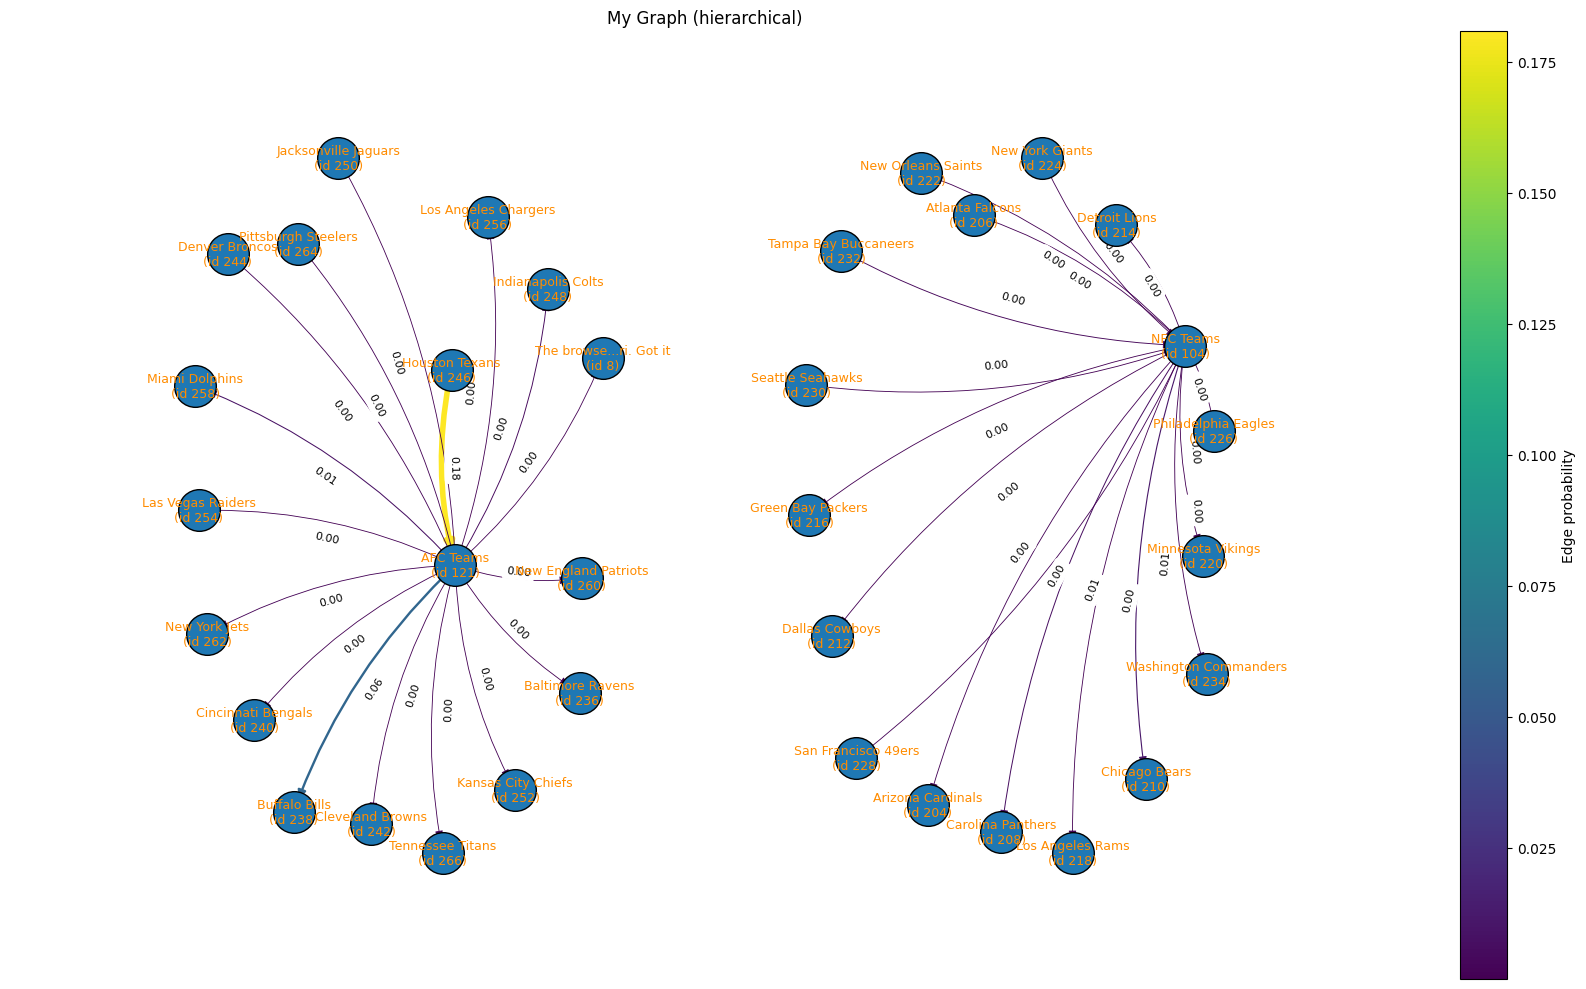

{'G': <networkx.classes.digraph.DiGraph at 0x7df25c1c4e60>,
 'pos': {246: (np.float64(0.6288494026280501), np.float64(0.6949966854393016)),
  121: (np.float64(0.6386126903949454), np.float64(0.41351259353549696)),
  238: (np.float64(0.24164856899910134), np.float64(0.05871735540956324)),
  258: (np.float64(0.0), np.float64(0.6713242193784617)),
  248: (np.float64(0.865671605167306), np.float64(0.8111141902333749)),
  244: (np.float64(0.07952630044820688), np.float64(0.8611175418614609)),
  236: (np.float64(0.9432507923546228), np.float64(0.23005888368823568)),
  262: (np.float64(0.029810938197766836), np.float64(0.3147456999329822)),
  264: (np.float64(0.252473391637316), np.float64(0.876244436595862)),
  242: (np.float64(0.4322645556430984), np.float64(0.04050695381371873)),
  252: (np.float64(0.7848539937119268), np.float64(0.08977622553089608)),
  240: (np.float64(0.1442568079064211), np.float64(0.1906795647613929)),
  256: (np.float64(0.7179116439222072), np.float64(0.9140973861363

In [45]:
# Display the graph
textmask = np.array([True]*len(new_txts))
#textmask = filterTextMask(new_txts, "Panavision", False) #& mask = keepTopKMask(txts, 1)

numToShow=len(textmask)
for row in zip(new_edges[textmask][:numToShow], new_xpaths[textmask][:numToShow], new_txts[textmask][:numToShow], new_probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=new_txts[textmask][:numToShow],
    id_edge_pairs=new_edges[textmask][:numToShow],
    xpath_edge_pairs=new_xpaths[textmask][:numToShow],
    probs=new_probs[textmask][:numToShow],
    layout="spring",
    rankdir="LR",         # or "TB" for top→bottom
    layer_spacing=1.5,    # spread layers further
    node_spacing=10,     # spread nodes within a layer
    figsize=(16, 10),
    title="My Graph (hierarchical)",
)

['Houston Texans' 'AFC Teams']
['AFC Teams' 'Houston Texans']
['Buffalo Bills' 'AFC Teams']
['AFC Teams' 'Buffalo Bills']
['Chicago Bears' 'NFC Teams']
['NFC Teams' 'Chicago Bears']
['Carolina Panthers' 'NFC Teams']
['NFC Teams' 'Carolina Panthers']
['AFC Teams' 'Miami Dolphins']
['Miami Dolphins' 'AFC Teams']
['NFC Teams' 'Tampa Bay Buccaneers']
['Tampa Bay Buccaneers' 'NFC Teams']
['Indianapolis Colts' 'AFC Teams']
['AFC Teams' 'Indianapolis Colts']
['NFC Teams' 'Washington Commanders']
['Washington Commanders' 'NFC Teams']
['Arizona Cardinals' 'NFC Teams']
['NFC Teams' 'Arizona Cardinals']
['Denver Broncos' 'AFC Teams']
['AFC Teams' 'Denver Broncos']
['Dallas Cowboys' 'NFC Teams']
['NFC Teams' 'Dallas Cowboys']
['Baltimore Ravens' 'AFC Teams']
['AFC Teams' 'Baltimore Ravens']
['Detroit Lions' 'NFC Teams']
['NFC Teams' 'Detroit Lions']
['AFC Teams' 'New York Jets']
['New York Jets' 'AFC Teams']
['AFC Teams' 'Pittsburgh Steelers']
['Pittsburgh Steelers' 'AFC Teams']
['Green Bay Packer

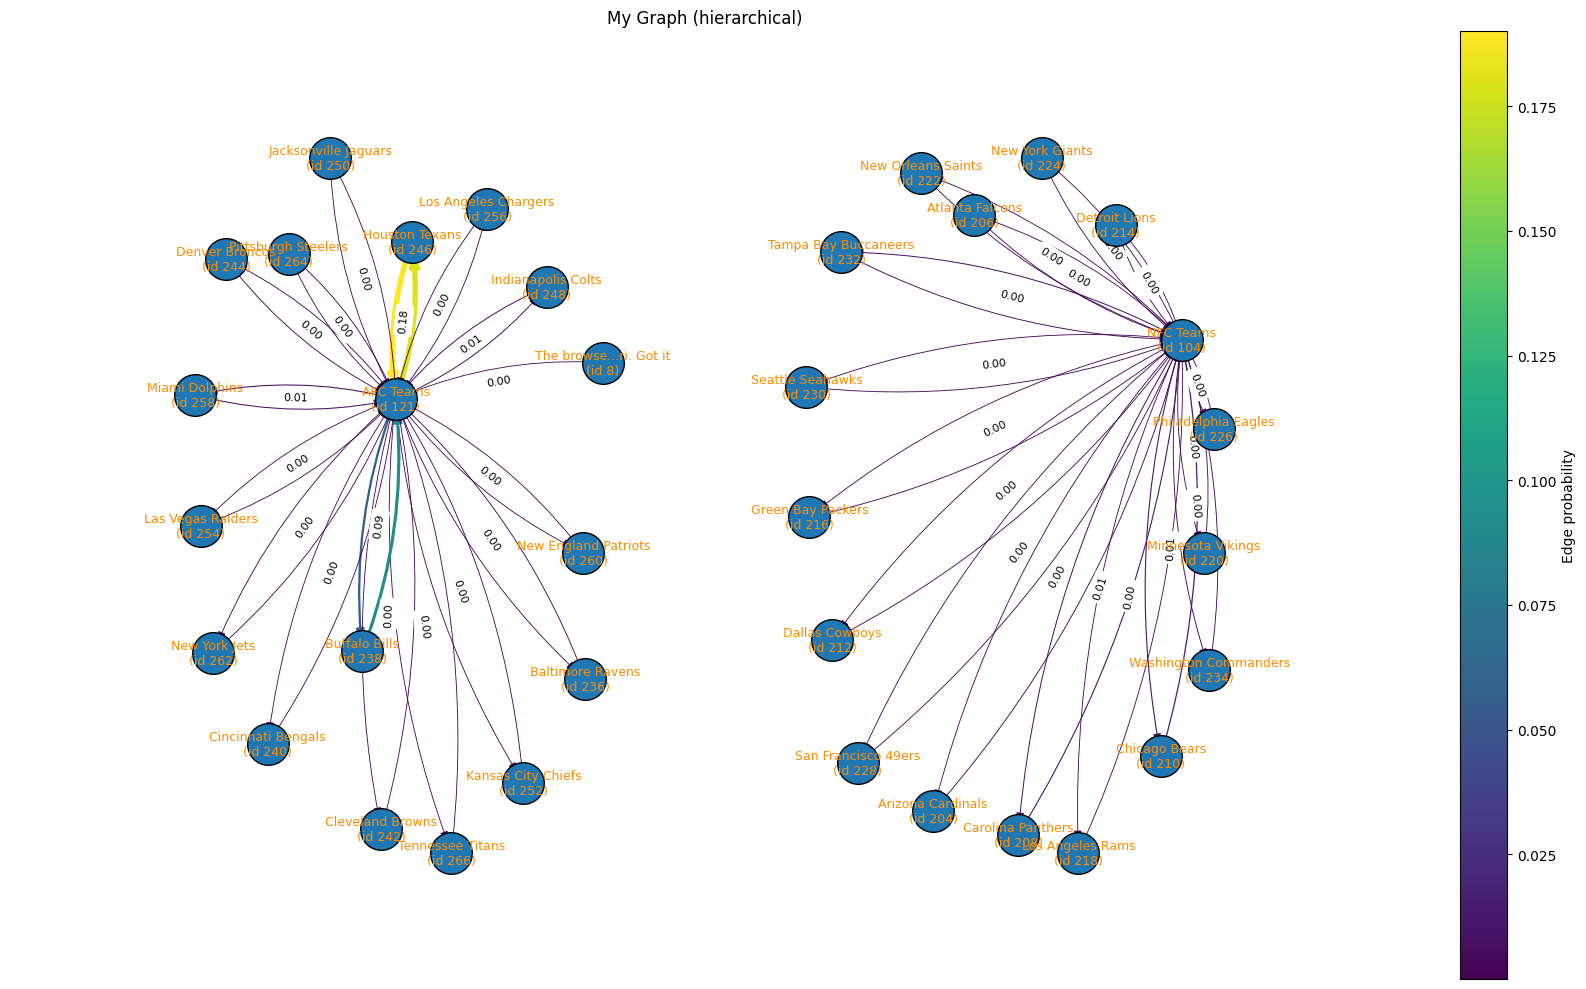

{'G': <networkx.classes.digraph.DiGraph at 0x7df2c729baa0>,
 'pos': {246: (np.float64(0.5317691174582698), np.float64(0.8789807534953016)),
  121: (np.float64(0.4917841306346084), np.float64(0.6527459783399314)),
  238: (np.float64(0.40977385826486135), np.float64(0.28952985793872227)),
  258: (np.float64(0.0), np.float64(0.6583833072146535)),
  248: (np.float64(0.8622431494364903), np.float64(0.8144106788953503)),
  244: (np.float64(0.07580806239466983), np.float64(0.8538478052455112)),
  236: (np.float64(0.9569229129743887), np.float64(0.24911339812378197)),
  262: (np.float64(0.04417826492918314), np.float64(0.287755668707085)),
  264: (np.float64(0.22955331343519508), np.float64(0.8618484866369986)),
  242: (np.float64(0.45671404119827136), np.float64(0.033447104204575376)),
  252: (np.float64(0.8052173864305466), np.float64(0.10061972805591454)),
  240: (np.float64(0.1774940835456714), np.float64(0.1561888175674768)),
  256: (np.float64(0.7163969596467018), np.float64(0.9262782598

In [46]:
# Display the graph
textmask = np.array([True]*len(txts))
#textmask = filterTextMask(new_txts, "Panavision", False) #& mask = keepTopKMask(txts, 1)

numToShow=len(textmask)
for row in zip(sorted_label_index[textmask][:numToShow], xpaths[textmask][:numToShow], txts[textmask][:numToShow], probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=txts[textmask][:numToShow],
    id_edge_pairs=sorted_label_index[textmask][:numToShow],
    xpath_edge_pairs=xpaths[textmask][:numToShow],
    probs=probs[textmask][:numToShow],
    layout="spring",
    rankdir="LR",         # or "TB" for top→bottom
    layer_spacing=1.5,    # spread layers further
    node_spacing=10,     # spread nodes within a layer
    figsize=(16, 10),
    title="My Graph (hierarchical)",
)